In [74]:
import sys
import os
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from IPython.display import Image, display
from enum import Enum
from operator import add
from typing import TypedDict, Annotated, List, Dict, Any, Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import add_messages, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.utilities import GoogleSerperAPIWrapper

load_dotenv(override=True)

True

In [75]:
mini_llm = ChatOpenAI(model="gpt-4o-mini")
serper = GoogleSerperAPIWrapper()
tool_web_search = Tool(
    name="web_search",
    func=serper.run,
    description="Useful for when you need more information from the web about a query"
)
llm_with_web_search_tools = mini_llm.bind_tools([tool_web_search])

In [76]:
reasoning_llm = ChatOpenAI(model="gpt-5")

In [77]:
class DomainTask(BaseModel):
    """Schema for individual domain tasks"""
    domain: str = Field(description="The domain name (compute, network, storage, database, etc)")
    task_description: str = Field(description="Clear description of the task for this domain")
    requirements: List[str] = Field(description="Key requirements and constraints for this domain")
    deliverables: List[str] = Field(description="Expected deliverables for this domain")

In [78]:
class TaskDecomposition(BaseModel):
    """Schema for the complete task decomposition"""
    user_problem: str = Field(description="The original user problem")
    decomposed_tasks: List[DomainTask] = Field(description="List of domain-specific tasks")
    overall_architecture_goals: List[str] = Field(description="High-level architecture goals")
    constraints: List[str] = Field(description="Global constraints that apply to all domains")

In [79]:
def merge_dicts(left: Dict[str, Any], right: Dict[str, Any]) -> Dict[str, Any]:
    """Merge two dictionaries, with right taking precedence over left."""
    result = left.copy()
    result.update(right)
    return result

def last_value(left: Any, right: Any) -> Any:
    """Keep the last value (right takes precedence)."""
    return right

class State(TypedDict):
    messages: Annotated[List, add_messages]
    user_problem: Annotated[str, last_value]
    iteration_count: Annotated[int, last_value]
    
    architecture_domain_tasks: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    architecture_components: Annotated[Dict[str, Dict[str, Any]], merge_dicts]

    proposed_architecture: Annotated[Dict[str, Any], merge_dicts]

    validation_feedback: Annotated[List[Dict[str, Any]], add]
    audit_feedback: Annotated[List[Dict[str, Any]], add]

    factual_errors_exist: Annotated[bool, last_value]
    design_flaws_exist: Annotated[bool, last_value]

    final_architecture: Annotated[Optional[Dict[str, Any]], last_value]
    architecture_summary: Annotated[Optional[str], last_value]

In [80]:
def architect_supervisor(state: State) -> State:
    """
    Orchestrates the architecture generation process using structured output for task decomposition.
    """
    print("---  Supervising ---")
    system_prompt = f"""
    You are an architect supervisor for AWS cloud architecture.
    Your role is to decompose the user's problem into structured domain-specific tasks and assign them to different architect domain agents.

    User Problem: {state["user_problem"]}
    Current Iteration: {state["iteration_count"]}
    Available feedback:
    - Validation feedback: {state.get("validation_feedback", [])}
    - Audit feedback: {state.get("audit_feedback", [])}

    Proposed Architecture: {state["proposed_architecture"]}
    Architecture Components: {state["architecture_components"]}

    Decompose the problem into structured tasks for these domains:
    1. compute (EC2, Lambda, ECS, EKS, Auto Scaling, etc.)
    2. network (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, etc.)
    3. storage (S3, EBS, EFS, etc.)
    4. database (RDS, DynamoDB, ElastiCache, etc.)

    For each domain, provide a Clear task description, Key requirements, constraints and Expected deliverables.
    Also provide overall architecture goals and global constraints.
    Ensure your output matches the TaskDecomposition schema perfectly.
    """

    # Create LLM with structured output
    structured_llm = reasoning_llm.with_structured_output(TaskDecomposition)
    
    messages = [SystemMessage(content=system_prompt)]
    response = structured_llm.invoke(messages)

    # Prepare the state update for architecture_domain_tasks
    domain_tasks_update = {
        "decomposition": response.dict(),
        "overall_goals": response.overall_architecture_goals,
        "constraints": response.constraints
    }
    
    for task in response.decomposed_tasks:
        domain_key = task.domain.lower()
        domain_tasks_update[domain_key] = {
            "task_description": task.task_description,
            "requirements": task.requirements,
            "deliverables": task.deliverables
        }

    # Return *only* the updated parts of the state
    return {
        "messages": [AIMessage(content=f"Task decomposition complete. Assigning to domain architects.")],
        "architecture_domain_tasks": domain_tasks_update,
        "iteration_count": state["iteration_count"] + 1 # Increment iteration count
    }

In [81]:
def create_initial_state(user_problem: str) -> State:
    """
    Create the initial state for the architecture generation process.
    """
    return {
        "messages": [HumanMessage(content=user_problem)],
        "user_problem": user_problem,
        # "current_phase": Phase.GENERATE,
        "iteration_count": 0,
        "architecture_domain_tasks": {},
        "architecture_components": {},
        "proposed_architecture": {},
        "validation_feedback": [],
        "audit_feedback": [],
        "factual_errors_exist": False,
        "design_flaws_exist": False,
        "final_architecture": None,
        "architecture_summary": None
    }

In [82]:
def compute_architect(state: State) -> State:
    """
    Implements the AWS compute domain architect agent using task information.
    """
    print("--- Compute architect ---")
    # Get structured task information for compute domain
    compute_task = state["architecture_domain_tasks"].get("compute", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are a compute domain architect for AWS.
    Design the compute infrastructure based on the following task.

    Original Problem: {state["user_problem"]}
    
    Your Specific Task:
    - Description: {compute_task.get('task_description', 'Design compute infrastructure')}
    - Requirements: {compute_task.get('requirements', [])}
    - Expected Deliverables: {compute_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design compute components (EC2, Lambda, ECS/EKS, Auto Scaling, etc.).
    Use web search if you need specific, up-to-date information.
    Provide detailed configuration recommendations.
    Focus *only* on the compute domain.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    return {
        "messages": [AIMessage(content=response.content, name="compute_architect")],
        "architecture_components": {
            "compute": {
                "recommendations": response.content,
                "agent": "compute_architect",
                "task_info": compute_task
            }
        }
    }

In [83]:
def network_architect(state: State) -> State:
    """AWS network domain architect using task information."""
    print("--- Network architect ---")
    # Get structured task information for network domain
    network_task = state["architecture_domain_tasks"].get("network", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Network Domain Architect.
    Design the network infrastructure based on the task.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {network_task.get('task_description', 'Design network infrastructure')}
    - Requirements: {network_task.get('requirements', [])}
    - Expected Deliverables: {network_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}
    
    Design network infrastructure (VPC, Subnets, ALB, CloudFront, Route 53, Security Groups, etc.).
    Use web search if you need specific, up-to-date information.
    Provide detailed network architecture.
    Focus *only* on the network domain.
    """
    
    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    return {
        "messages": [AIMessage(content=response.content, name="network_architect")],
        "architecture_components": {
            "network": {
                "recommendations": response.content,
                "agent": "network_architect",
                "task_info": network_task,
            }
        }
    }

In [84]:
def storage_architect(state: State) -> State:
    """AWS storage domain architect using task information."""
    print("--- Storage architect ---")
    # Get structured task information for storage domain
    storage_task = state["architecture_domain_tasks"].get("storage", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Storage Domain Architect.
    Design the storage infrastructure based on the task.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {storage_task.get('task_description', 'Design storage infrastructure')}
    - Requirements: {storage_task.get('requirements', [])}
    - Expected Deliverables: {storage_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design storage infrastructure (S3, EBS, EFS, Glacier, etc.).
    Use web search if you need specific, up-to-date information.
    Provide detailed storage architecture.
    Focus *only* on the storage domain.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    return {
        "messages": [AIMessage(content=response.content, name="storage_architect")],
        "architecture_components": {
            "storage": {
                "recommendations": response.content,
                "agent": "storage_architect",
                "task_info": storage_task,
            }
        }
    }

In [85]:
def database_architect(state: State) -> State:
    """AWS database domain architect using task information."""
    print("--- Database architect ---")
    # Get structured task information for database domain
    database_task = state["architecture_domain_tasks"].get("database", {})
    overall_goals = state["architecture_domain_tasks"].get("overall_goals", [])
    constraints = state["architecture_domain_tasks"].get("constraints", [])
    
    system_prompt = f"""
    You are an AWS Database Domain Architect.
    Design the database infrastructure based on the structured task decomposition.

    Original Problem: {state['user_problem']}
    
    Your Specific Task:
    - Description: {database_task.get('task_description', 'Design database infrastructure')}
    - Requirements: {database_task.get('requirements', [])}
    - Expected Deliverables: {database_task.get('deliverables', [])}
    
    Overall Architecture Goals: {overall_goals}
    Global Constraints: {constraints}

    Design database infrastructure (RDS, DynamoDB, ElastiCache, etc.).
    Use web search if you need specific, up-to-date information.
    Provide detailed database architecture.
    Focus *only* on the database domain.
    """         

    messages = [SystemMessage(content=system_prompt)]
    response = llm_with_web_search_tools.invoke(messages)

    return {
        "messages": [AIMessage(content=response.content, name="database_architect")],
        "architecture_components": {
            "database": {
                "recommendations": response.content,
                "agent": "database_architect",
                "task_info": database_task,
            }
        }
    }

In [86]:
def architect_synthesizer(state: State) -> State:
    """
    Synthesizes the architecture components provided by the architect agents into a coherent architecture.
    """
    print("--- Architect synthesizer ---")
    all_components = state.get("architecture_components", {})
    component_summaries = []
    for domain, info in all_components.items():
        # Check if recommendations are empty
        recommendation = info.get('recommendations', 'No recommendations provided.')
        if not recommendation.strip():
            recommendation = "No recommendations provided for this domain."
            
        component_summaries.append(f"**{domain.capitalize()} Domain:**\n{recommendation}\n")    
    system_prompt = f"""
    You are an AWS Principal Solutions Architect.
    You have received architecture designs from your domain specialist architects.
    Your job is to synthesize these components into a single, coherent, and final architecture proposal.

    Original Problem: {state['user_problem']}
    Overall Goals: {state["architecture_domain_tasks"].get("overall_goals", [])}
    Global Constraints: {state["architecture_domain_tasks"].get("constraints", [])}

    Component Designs from Domain Architects:
    {"---".join(component_summaries)}

    Synthesize all these pieces into a final, unified architecture.
    Ensure the components work together.
    Provide a high-level summary and then the detailed, integrated design.
    """
    messages = [SystemMessage(content=system_prompt)]
    response = reasoning_llm.invoke(messages)

    return {
        "messages": [AIMessage(content=response.content, name="architect_synthesizer")],
        "proposed_architecture": {
            "architecture_summary": response.content,
            "source_components": all_components
        }
    }

In [88]:
tool_web_search_node = ToolNode(tools=[tool_web_search])

In [89]:
def web_search_tool_condition(state: State) -> bool:
    last_message = state["messages"][-1]
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "synthesizer"

In [93]:
graph_builder = StateGraph(State)

graph_builder.add_node("architect_supervisor", architect_supervisor)
graph_builder.add_node("compute_architect", compute_architect)
graph_builder.add_node("network_architect", network_architect)
graph_builder.add_node("storage_architect", storage_architect)
graph_builder.add_node("database_architect", database_architect)
graph_builder.add_node("architect_synthesizer", architect_synthesizer)

# Parallel execution with Annotated types to handle multiple values
graph_builder.add_edge(START, "architect_supervisor")
graph_builder.add_edge("architect_supervisor", "compute_architect")
graph_builder.add_edge("architect_supervisor", "network_architect")
graph_builder.add_edge("architect_supervisor", "storage_architect")
graph_builder.add_edge("architect_supervisor", "database_architect")

graph_builder.add_node("web_search", tool_web_search_node)
graph_builder.add_conditional_edges("compute_architect", web_search_tool_condition, {"tools": "web_search", "synthesizer": "architect_synthesizer"})
graph_builder.add_conditional_edges("network_architect", web_search_tool_condition, {"tools": "web_search", "synthesizer": "architect_synthesizer"})
graph_builder.add_conditional_edges("storage_architect", web_search_tool_condition, {"tools": "web_search", "synthesizer": "architect_synthesizer"})
graph_builder.add_conditional_edges("database_architect", web_search_tool_condition, {"tools": "web_search", "synthesizer": "architect_synthesizer"})

graph_builder.add_edge("web_search", "compute_architect")
graph_builder.add_edge("web_search", "network_architect")
graph_builder.add_edge("web_search", "storage_architect")
graph_builder.add_edge("web_search", "database_architect")

graph_builder.add_edge("compute_architect", "architect_synthesizer")
graph_builder.add_edge("network_architect", "architect_synthesizer")
graph_builder.add_edge("storage_architect", "architect_synthesizer")
graph_builder.add_edge("database_architect", "architect_synthesizer")

graph = graph_builder.compile()

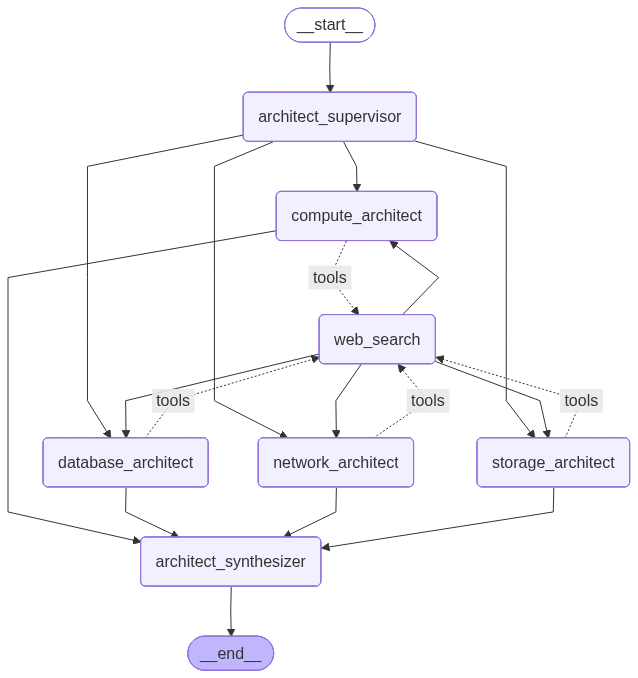

In [94]:
graph

In [95]:
result = graph.invoke({"user_problem": "I need a scalable web application that can handle 100 requests per second."})
result

---  Supervising ---


C:\Users\niran.NIRANJAN_GADE\AppData\Local\Temp\ipykernel_13996\3137843285.py:38: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  "decomposition": response.dict(),


--- Compute architect ---
--- Database architect ---
--- Network architect ---
--- Storage architect ---
--- Architect synthesizer ---


{'messages': [AIMessage(content='Task decomposition complete. Assigning to domain architects.', additional_kwargs={}, response_metadata={}, id='29102489-76bd-48f8-b0e1-4a40966dce65'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='compute_architect', id='02e7a256-3fcd-4d5d-bb9e-913175059cd5'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='database_architect', id='b21cead5-fe6b-450e-9d4d-98551c2c0028'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='network_architect', id='033ca9b5-4b7f-453f-a158-ed3243998541'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, name='storage_architect', id='e8afd910-87a1-4d95-ac8c-3e836da0ce71'),
  AIMessage(content='High-level summary\n- We will build a highly available, secure, and scalable web application stack using CloudFront + AWS WAF in front of an HTTPS ALB, terminating into an ECS on Fargate stateless application tier running across two Availabil

In [ ]:
def validator_supervisor(state: State) -> State:
    """
    Implements the validator supervisor for the architecture generation process.
    """

    system_prompt = f"""
    You are a validator supervisor for the AWS cloud architecture.
    Supervise the domain validation of the architecture components for factual correctness.

    Original Problem: {state['user_problem']}
    Architecture components to validate: {state["architecture_components"]}
    Proposed architecture: {state['proposed_architecture']}

    Based on the user's problem, decompse the architecture into domain components and assign them to different domain validator agents respectively.

    For each domain, provide the proposed components and their respective AWS services.

    Format your response as a structured breakdown for each domain.
    """

    messages = [SystemMessage(content=system_prompt)]
    response = reasoning_llm.invoke(messages)

    new_state = state.copy()
    new_state["messages"].append(AIMessage(content=response.content))

    return new_state